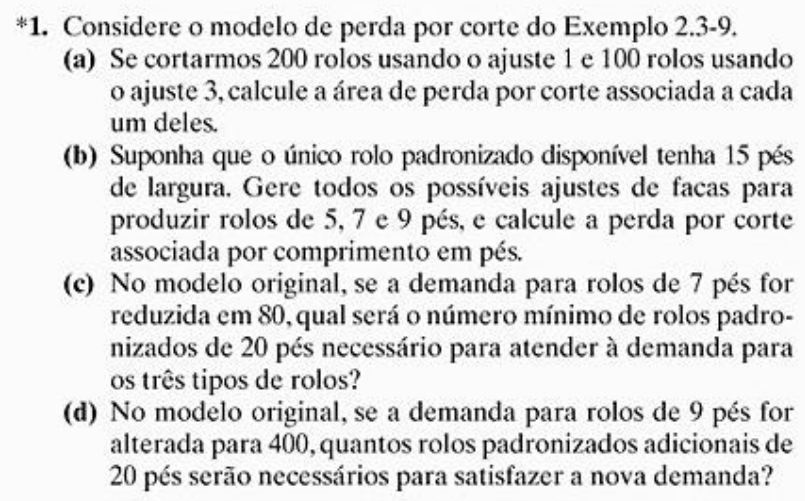

**Questão (a)**

Calcular a área de perda por corte para o ajuste 1 e o ajuste 3. A perda por corte é a largura do rolo padrão que não é utilizada.

Ajuste 1: Produz um rolo de 7 pés e um de 9 pés.

Largura utilizada: 7 + 9 = 16 pés.

Perda por corte: 20 (largura padrão) - 16 = 4 pés.

Ajuste 3: Produz dois rolos de 5 pés e um de 9 pés.

Largura utilizada: (2 * 5) + 9 = 19 pés.

Perda por corte: 20 (largura padrão) - 19 = 1 pé.

Se considerarmos a "área" para um comprimento L, a área de perda total para a operação descrita (200 rolos no ajuste 1 e 100 no ajuste 3) seria:
    (200 rolos * 4 pés * L) + (100 rolos * 1 pé * L) = 900 * L pés².

**Questão (b)**

Esta questão é autossuficiente e pede para gerar todos os padrões de corte possíveis para um rolo de 15 pés, produzindo rolos de 5, 7 e 9 pés.

A tabela abaixo lista todas as combinações viáveis e a perda associada.

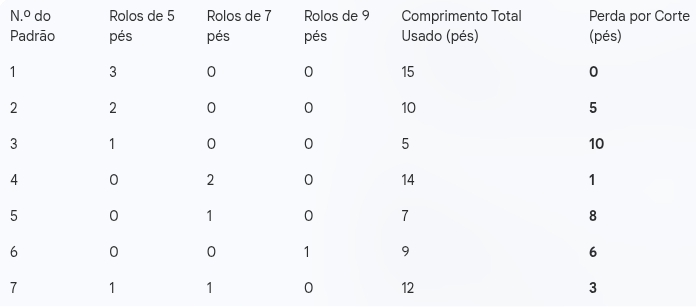

**Questões (c) e (d)**

In [2]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from docplex.mp.model import Model

In [4]:
# --- Parâmetros extraídos do Exemplo 2.3-9 ---

# Padrões de corte (ajustes). A matriz mostra quantos rolos de cada
# largura são produzidos por cada padrão.
# Linhas: Largura de 5, 7, 9 pés
# Colunas: Padrões de 1 a 6
padroes_corte = {
    #padrao: {largura: n_rolos}
    1: {5: 0, 7: 1, 9: 1},
    2: {5: 2, 7: 1, 9: 0},
    3: {5: 2, 7: 0, 9: 1},
    4: {5: 4, 7: 0, 9: 0},
    5: {5: 1, 7: 2, 9: 0},
    6: {5: 0, 7: 0, 9: 2}
}

# Demandas para cada cenário
demandas = {
    'original': {5: 150, 7: 200, 9: 300},
    'cenario_c': {5: 150, 7: 120, 9: 300}, # Demanda de 7' reduzida em 80
    'cenario_d': {5: 150, 7: 200, 9: 400}  # Demanda de 9' alterada para 400
}

In [5]:
resultados = {}

for cenario, demanda_atual in demandas.items():
    # Criação do modelo
    model = Model(f'PerdaPorCorte_{cenario}')

    # 1. Variáveis de Decisão
    # x[j] = número de rolos padrão a cortar conforme o ajuste j (inteiros)
    x = model.integer_var_dict(padroes_corte.keys(), name='x')

    # 2. Função Objetivo
    # Minimizar o número total de rolos padrão utilizados
    total_rolos_usados = model.sum(x[j] for j in padroes_corte.keys())
    model.minimize(total_rolos_usados)

    # 3. Restrições
    # A produção total de cada largura deve atender à demanda
    for largura in [5, 7, 9]:
        expressao_producao = (padroes_corte[j][largura] * x[j] for j in padroes_corte.keys())
        soma_producao = model.sum(expressao_producao)
        restr_demanda_logica = soma_producao >= demanda_atual[largura]
        model.add_constraint(restr_demanda_logica, ctname=f'demanda_{largura}pes')

    # Resolução
    solucao = model.solve() # log_output=True pode ser adicionado para ver o log
    if solucao:
        resultados[cenario] = model.objective_value
    else:
        resultados[cenario] = "Não resolvido"

In [6]:
print("------ RESULTADOS DAS OTIMIZAÇÕES ------\n")

# Resultado para a Questão (c)
print("Questão (c):")
rolos_c = resultados.get('cenario_c')
print(f"Com a demanda de rolos de 7 pés reduzida para 120, o número mínimo de rolos padrão necessários é de {int(rolos_c)}.\n")

# Resultados para a Questão (d)
print("Questão (d):")
rolos_orig = resultados.get('original')
rolos_d = resultados.get('cenario_d')
rolos_adicionais = rolos_d - rolos_orig
print(f"O número mínimo de rolos para a demanda original é de {int(rolos_orig)}.")
print(f"Com a demanda de rolos de 9 pés alterada para 400, o número mínimo de rolos necessários é de {int(rolos_d)}.")
print(f"Portanto, o número de rolos padronizados adicionais necessários é de {int(rolos_adicionais)}.")

------ RESULTADOS DAS OTIMIZAÇÕES ------

Questão (c):
Com a demanda de rolos de 7 pés reduzida para 120, o número mínimo de rolos padrão necessários é de 233.

Questão (d):
O número mínimo de rolos para a demanda original é de 263.
Com a demanda de rolos de 9 pés alterada para 400, o número mínimo de rolos necessários é de 313.
Portanto, o número de rolos padronizados adicionais necessários é de 50.
